In [ ]:
!pip install torchinfo

In [ ]:
import random
import time
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np

LEFTOVER SPACE FOR DL1,DL2 leftover


# CPUs vs GPUs

# **CPUs:**
Fewer Cores, More Features: CPUs typically have fewer cores (e.g., 4, 8, 16) compared to GPUs. Each core is designed to be a robust general-purpose processor, equipped with a wide range of instructions and sophisticated features like out-of-order execution and advanced branch prediction.

Cache Hierarchies: CPUs emphasize a complex memory hierarchy with multiple levels of cache (L1, L2, L3). This design aims to keep frequently accessed data close to the processing cores to reduce latency.

Task Switching: CPUs are optimized for low-latency task switching, ideal for general computing where many diverse tasks and processes must be handled in a multitasking environment.

Parallelization Implication: CPUs are well-suited for task parallelism where different tasks or threads can be executed independently and concurrently. However, the number of parallel tasks is generally limited by the number of cores.

# **GPUs:**
Massive Number of Cores: GPUs have a large number of smaller, simpler cores (potentially thousands). These cores are often grouped, with each group sharing certain resources like memory.

Simpler Cores: Each core in a GPU is simpler compared to a CPU core. It's optimized for throughput over latency and designed primarily for mathematical operations.

Shared Memory: Within each group of cores (or multiprocessors), there is shared memory that can be used for communication between threads in the group.

Parallelization Implication: GPUs excel at data parallelism, where the same operation is performed independently on many data elements simultaneously. For example, in graphics rendering, the same shading operation might be performed on each pixel. Or in deep learning, matrix multiplications and other tensor operations can be parallelized across the many cores.

# Role of GPUs in Deep Learning

Parallel Processing: GPUs can perform thousands of operations simultaneously.

Tensor Operations: Many operations in deep learning are tensor operations that can be parallelised.

Comparison with CPUs: Faster Speed, efficiency, but less use-cases.

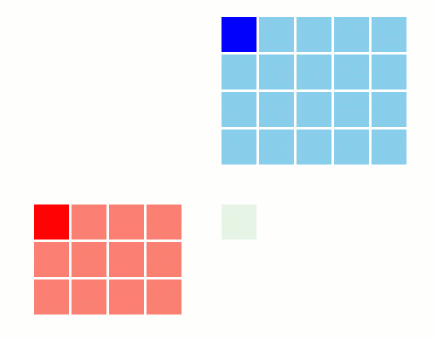

Originally used for faster rendering and more advanced graphics capabilities.

Deep learning's matrix multiplication also benefits from this architecture.

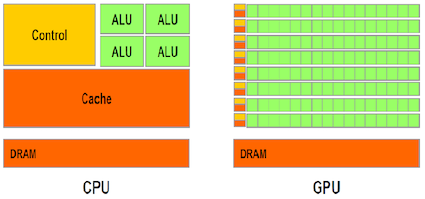

#MNIST example
First, we create the data

In [ ]:
batch_size = 64

#create a dataset object and download the data
data_train = torchvision.datasets.MNIST('./data',
    download=True,train=True,transform=torchvision.transforms.ToTensor())

#create a dataloader from the dataset object
train_loader = torch.utils.data.DataLoader(data_train,batch_size=batch_size)


100%|██████████| 9912422/9912422 [00:00<00:00, 109747094.34it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 66815054.51it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27476833.03it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6932506.83it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [26]:
class OneConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(5184,10)

    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = OneConv()
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Linear: 1-3                            [1, 10]                   51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

#CPU example

In [30]:
def trainNet(net,train_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.CrossEntropyLoss()):
    #the .to() method of pytorch objects move the object to vram if .to()"cuda"), or to ram if .to("cpu"
    net.to(default_device)
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    #make dictionary to track loss and accuracy of model while training
    res = { 'train_loss' : [], 'train_acc': []}
    for ep in range(epochs):
      #tells pytorch to compute gradient
      net.train()
      total_loss,acc,count = 0,0,0
      for features,labels in train_loader:
        #clear gradient calculations each backprop
        optimizer.zero_grad()
        #move labels to ram/vram
        lbls = labels.to("default_device")
        #move input to vram/ram then forward pass to obtain model output
        out = net(features.to(default_device))
        #find cross entropy loss
        loss = loss_fn(out,lbls)
        #backprop
        loss.backward()
        #make optimiser update gradients
        optimizer.step()

        #track training metrics
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==lbls).sum()
        count+=len(labels)

        tl, ta = total_loss.item()/count, acc.item()/count

      print(f"Epoch {ep:2}, Train acc={ta:.3f}, Train loss={tl:.3f}")
      res['train_loss'].append(tl)
      res['train_acc'].append(ta)

    return res

In [ ]:
#create the model
net = OneConv()
#for this example we use cpu
default_device = 'cpu'

#time the time needed for 100 epochs
start = time.time()
#time.time() above returns seconds since 1st Jan 1970
trainNet(net,train_loader,epochs=5)
print(time.time()-start)
#so time.time() - start above will return seconds taken to execute the training code


Epoch  0, Train acc=0.953, Train loss=0.002
Epoch  1, Train acc=0.979, Train loss=0.001
Epoch  2, Train acc=0.982, Train loss=0.001
Epoch  3, Train acc=0.985, Train loss=0.001
Epoch  4, Train acc=0.987, Train loss=0.001
83.35814619064331


# GPU example, same code

In [31]:
#create new model
net = OneConv()
#this time we will use GPU
default_device="cuda"

start = time.time()
trainNet(net,train_loader,epochs=5)
print(time.time()-start)

RuntimeError: ignored

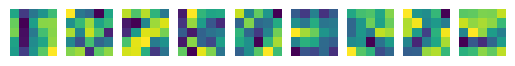

In [ ]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0])
        ax[i].axis('off')

In [ ]:
#we save a .pt file which has this model's weights for later
torch.save(net.state_dict(), "/content/data/mnist.pt")

#Importance of GPUs (additional info)





The model you've just used is only 0.25mb with 52,084 params. Larger models such as Llama, a open-source large language model, has 7B parameters and is about 20gb in size.
This does not include the dataset size.

The current GPU you are using (T4) has 15gb of vram, so you won't be able to run that model on GPU.

#Multiple GPU setup (additional info)

With multiple GPUs you can perform the following to speed up training or train larger models that cannot fit onto 1 gpu:

1. DataParallel (DP) - the same setup is replicated multiple times, and each being fed a slice of the data. The processing is done in parallel and all setups are synchronized at the end of each training step.

2. TensorParallel (TP) - each tensor is split up into multiple chunks, so instead of having the whole tensor reside on a single gpu, each shard of the tensor resides on its designated gpu. During processing each shard gets processed separately and in parallel on different GPUs and the results are synced at the end of the step. This is what one may call horizontal parallelism, as the splitting happens on horizontal level.

3. PipelineParallel (PP) - the model is split up vertically (layer-level) across multiple GPUs, so that only one or several layers of the model are places on a single gpu. Each gpu processes in parallel different stages of the pipeline and working on a small chunk of the batch.

4. Zero Redundancy Optimizer (ZeRO) - Also performs sharding of the tensors somewhat similar to TP, except the whole tensor gets reconstructed in time for a forward or backward computation, therefore the model doesn’t need to be modified. It also supports various offloading techniques to compensate for limited GPU memory.

5. Sharded DDP - is another name for the foundational ZeRO concept as used by various other implementations of ZeRO.

#Additional example on GPU speedup

In [ ]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))

        #view function changes the dimension of the matrix from [1, 20, 4, 4] to [1, 320]
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = MultiLayerCNN()
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

In [ ]:
#create new model
net = MultiLayerCNN()
default_device="cpu"

start = time.time()
trainNet(net,train_loader,epochs=5)
print("MultiLayerCNN on CPU took",time.time()-start,"seconds")

Epoch  0, Train acc=0.960, Train loss=0.002
Epoch  1, Train acc=0.980, Train loss=0.001
Epoch  2, Train acc=0.983, Train loss=0.001
Epoch  3, Train acc=0.983, Train loss=0.001
Epoch  4, Train acc=0.985, Train loss=0.001
MultiLayerCNN on CPU took 109.34377932548523 seconds


In [ ]:
#create new model
net = MultiLayerCNN()
default_device="cuda"

start = time.time()
trainNet(net,train_loader,epochs=5)
print("MultiLayerCNN on GPU took",time.time()-start,"seconds")

Epoch  0, Train acc=0.958, Train loss=0.002
Epoch  1, Train acc=0.979, Train loss=0.001
Epoch  2, Train acc=0.982, Train loss=0.001
Epoch  3, Train acc=0.983, Train loss=0.001
Epoch  4, Train acc=0.983, Train loss=0.001
MultiLayerCNN on GPU took 42.55301070213318 seconds


# Autograd
Automatic differentiation package in the PyTorch library. Tracks every operation made on a tensor to back propagate by chain rule.

Find out more or view a more thorough example at the [official torch website](https://pytorch.org/tutorials/beginner/former_torchies/autograd_tutorial.html).



In [ ]:
class GradMultiLayerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320,10)

    def forward(self, x):
        x = self.conv1(x)
        print(x.grad_fn)
        x = nn.functional.relu(x)
        print(x.grad_fn)
        x = self.pool(nn.functional.relu(self.conv2(self.pool(x))))
        print(x.grad_fn)
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = GradMultiLayerCNN()


In [ ]:
0.1+0.2

0.30000000000000004

# Floating point operations and their Impact

Model parameters and data are represented with FP32 by default and is supported by virtually all GPUs

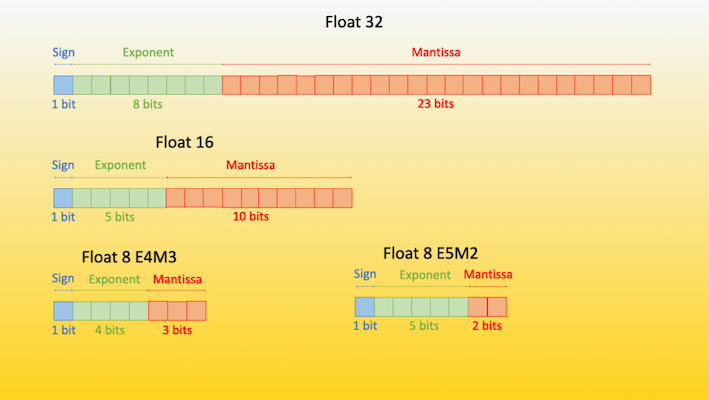


However, you can reduce the precision to FP16 or even 8 or 4 bits to reduce the model size and make training/inference faster.

However, this usually comes at the cost of
1. **Model performance** - lower precision may not be able to fit the data's trends and intricacies well.

2. **Underflow or overflow** - very small numbers becomes zero and very large numbers become NaN, this either makes your model learn nothing or garbage.

So a mixed precision method is used when we lower precision to address the problems.

1. Make an FP16 copy of the weights
2. Forward propagate using FP16 weights and activations
3. Multiply the resulting loss by the scale factor S
4. Backward propagate using FP16 weights, activations, and their gradients
5. Multiply the weight gradients by 1/S
6. Optionally process the weight gradients (gradient clipping, weight decay, etc.)
7. Update the master copy of weights in FP32

Done in torch with the automated mixed precision package - torch amp

Visit the links at the bottom for more info


In [ ]:
class LargeMultiLayerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320,10)


    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = LargeMultiLayerCNN()
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
LargeMultiLayerCNN                       [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

In [ ]:
def trainNetMixedPrecision(net,train_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.CrossEntropyLoss()):
    #the .to() method of pytorch objects move the object to vram if .to()"cuda"), or to ram if .to("cpu"
    net.to(default_device)
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    #make dictionary to track loss and accuracy of model while training
    res = { 'train_loss' : [], 'train_acc': []}
    for ep in range(epochs):
      #tells pytorch to compute gradient
      net.train()
      total_loss,acc,count = 0,0,0
      for features,labels in train_loader:
        optimizer.zero_grad()
        lbls = labels.to(default_device)

        with torch.autocast(device_type='cuda', dtype=torch.float16): #Context manager
          out = net(features.to(default_device))
          loss = loss_fn(out,lbls)

        loss.backward()
        optimizer.step()

        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==lbls).sum()
        count+=len(labels)

        tl, ta = total_loss.item()/count, acc.item()/count

      print(f"Epoch {ep:2}, Train acc={ta:.3f}, Train loss={tl:.3f}")
      res['train_loss'].append(tl)
      res['train_acc'].append(ta)

    return res

In [ ]:
#create new model
net = LargeMultiLayerCNN()
default_device="cuda"

start = time.time()
trainNet(net,train_loader,epochs=5)
print("MultiLayerCNN on GPU took",time.time()-start,"seconds")

Epoch  0, Train acc=0.957, Train loss=0.002
Epoch  1, Train acc=0.979, Train loss=0.001
Epoch  2, Train acc=0.982, Train loss=0.001
Epoch  3, Train acc=0.983, Train loss=0.001
Epoch  4, Train acc=0.985, Train loss=0.001
MultiLayerCNN on GPU took 45.97688913345337 seconds


In [ ]:
#create new model
net = LargeMultiLayerCNN()
default_device="cuda"

start = time.time()
trainNetMixedPrecision(net,train_loader,epochs=5)
print("MultiLayerCNN on GPU took",time.time()-start,"seconds")

Epoch  0, Train acc=0.957, Train loss=0.002
Epoch  1, Train acc=0.980, Train loss=0.001
Epoch  2, Train acc=0.983, Train loss=0.001
Epoch  3, Train acc=0.983, Train loss=0.001
Epoch  4, Train acc=0.983, Train loss=0.001
MultiLayerCNN on GPU took 44.59488296508789 seconds


# Tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()

#Make our pixels only have range 0-1 instead of 0-255, to inrcease stability and reduced Computation
#Concept mentioned last lesson
#We did not do this for torch as the data comes in range 0-1 already
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
with tf.device('/cpu:0'):
  model = keras.models.Sequential([
      keras.layers.Conv2D(filters=10, kernel_size=(5,5), input_shape=(28,28,1),activation='relu'),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(filters=20, kernel_size=(5,5), activation='relu'),
      keras.layers.MaxPooling2D(),
      keras.layers.Flatten(),
      keras.layers.Dense(10)
  ])

  #Loss function is Sparse Categorical Cross entropy, basically the same as the pytorch version.
  #The "sparse" word just refers to the input not being one-hot encoded. (our ouput is [0.4,0.1, ....] comapred to [1,0,0 ...])
  model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])

  #prints model summary similarly to torchinfo's summary
  model.summary()

  #We have to reshape our data as follows because TF expects our input for conv2d to have 3 dimensions, for RGB
  x_train_c = np.expand_dims(x_train,3)
  x_test_c = np.expand_dims(x_test,3)


  start = time.time()
  model.fit(x_train_c,y_train,validation_data=(x_test_c,y_test),epochs=1)
  print("\nTraining MultiLayerCNN with TF on CPU took",time.time()-start,"seconds")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 10)        260       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 10)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 20)          5020      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 20)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 10)                3

In [ ]:
with tf.device('/device:GPU:0'):
  model = keras.models.Sequential([
      keras.layers.Conv2D(filters=10, kernel_size=(5,5), input_shape=(28,28,1),activation='relu'),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(filters=20, kernel_size=(5,5), activation='relu'),
      keras.layers.MaxPooling2D(),
      keras.layers.Flatten(),
      keras.layers.Dense(10)
  ])

  model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])


  start = time.time()
  model.fit(x_train_c,y_train,validation_data=(x_test_c,y_test),epochs=1)
  print("\nTraining MultiLayerCNN with TF on GPU took",time.time()-start,"seconds")

1875/1875 [==============================] - 9s 4ms/step - loss: 0.2170 - acc: 0.9352 - val_loss: 0.0769 - val_acc: 0.9766

Training MultiLayerCNN with TF on GPU took 11.0398850440979 seconds


#Links for further info

[Perspective matrix in 3D rendering](https://www.youtube.com/watch?v=U0_ONQQ5ZNM)

[Multiple GPU usage](https://huggingface.co/docs/transformers/perf_train_gpu_many)

[PyTorch AMP](https://pytorch.org/docs/stable/amp.html)

[Nvidia blog on mixed precision](https://developer.nvidia.com/blog/mixed-precision-training-deep-neural-networks/)






# THIS IS STREAMLIT CODE, DO NOT RUN IN COLAB

In [ ]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import streamlit as st
from streamlit_drawable_canvas import st_canvas



class OneConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(5184,10)

    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

#load the model
model = OneConv()
model.load_state_dict(torch.load("PATH_TO_.pt_FILE",map_location=torch.device('cpu')))
model.eval()

#these add text to the frontend
st.title('My MNIST model')
st.markdown('''
Try to write a digit!
''')


SIZE = 192

canvas_result = st_canvas(
    fill_color='#000000',
    stroke_width=20,
    stroke_color='#FFFFFF',
    background_color='#000000',
    width=SIZE,
    height=SIZE,
    drawing_mode="freedraw",
    key='canvas')


#process the image only if there is drawing
if canvas_result.image_data:
    #resize the 192x192 canvas drawing to 28x28
    img = cv2.resize(canvas_result.image_data.astype('uint8'), (28, 28))
    #display the resized image (if you dont resize it back to 192x192, it'll show up as a small image)
    rescaled = cv2.resize(img, (SIZE, SIZE), interpolation=cv2.INTER_AREA)
    st.write('Model Input')
    st.image(rescaled)

#if predict button is pressed
if st.button('Predict'):
    #convert image from colour to gray
    test_x = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #change the values from [0,255] to [0,1] then convert the numpy array to a torch tensor
    bwx = torch.from_numpy(test_x.reshape(1, 28, 28)/255)
    #change input to float from double then unsqueeze changes from (1,28,28) to (1,1,28,28)
    val = model(bwx.float().unsqueeze(0))
    #result will be a one-hot tensor
    st.write(f'result: {np.argmax(val.detach().numpy()[0])}')
    #display the one-hot tensor output
    st.bar_chart(np.exp(val.detach().numpy()[0]))
    print(np.exp(val.detach().numpy()[0]))

ModuleNotFoundError: ignored